# Prior Language Models

*Computing of $p(x)$*

Run this before continuing so that the imports work.

In [15]:
from os import chdir, getcwd

if getcwd().endswith('notebooks'):
    chdir('..')

In [16]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data loading

### Vocabulary initialisation

In [17]:
from data.vocab import vocabulary
from models.types import EOS_TOKEN, SOS_TOKEN, PADDING_TOKEN

print('|IPA| =', len(vocabulary)-3) # '-3' because `vocabulary` contains the IPA characters plus the special tokens listed below
for token in (SOS_TOKEN, EOS_TOKEN, PADDING_TOKEN):
    print(token, vocabulary[token])

|IPA| = 57
( 57
) 58
- 59


### Dataset initialisation

In [18]:
from data.getDataset import getLMTrainingSet

# Following 'Article Scientifique' there are three db of different sizes.
DB_SIZE = [20_000, 10_000, 5_000]

# Generate the three db of different sizes.
tokens_20k, tokens_10k, tokens_5k = getLMTrainingSet(DB_SIZE)

### Training load

In [19]:
from torch.utils.data.backward_compatibility import worker_init_fn
from torch.utils.data import DataLoader
from torchtext.datasets import CC100

dp = CC100(root='./out/cache', language_code='la')
DataLoader(dp, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn, drop_last=True)

### Evaluation load

In [20]:
from data.getDataset import getIteration
from data.vocab import wordsToOneHots, computeInferenceData_Samples

sources = computeInferenceData_Samples(wordsToOneHots(getIteration(3), device))
print(sources)

(tensor([[[57],
         [57],
         [57],
         ...,
         [57],
         [57],
         [57]],

        [[32],
         [ 0],
         [ 0],
         ...,
         [22],
         [ 2],
         [ 2]],

        [[ 1],
         [ 1],
         [ 1],
         ...,
         [32],
         [ 6],
         [ 6]],

        ...,

        [[59],
         [59],
         [59],
         ...,
         [59],
         [59],
         [59]],

        [[59],
         [59],
         [59],
         ...,
         [59],
         [59],
         [59]],

        [[59],
         [59],
         [59],
         ...,
         [59],
         [59],
         [59]]], device='cuda:0', dtype=torch.int32), tensor([[7],
        [9],
        [9],
        ...,
        [6],
        [5],
        [5]]), 19)


## RNN LM

### Initialisation

In [21]:
from torch.cuda import is_available
from lm.PriorLM import CharLM

device = 'cuda' if is_available() else 'cpu'

# Init the character level LSTM language model 
LSTM_lm = CharLM(embedding_size=1024, hidden_size=100, num_layers=2, dropout_rate=0.1, device=device, vocab=vocabulary)

### Training

***`TODO`***

### Inference

In [22]:
#probs = LSTM_lm.inference(sources)
#print(f"p('{word}') =", probs[testIndexInBatch].item())

## $n$-gram LM

### Initialisation

In [23]:
from lm.PriorLM import NGramLM

bigram_20k = NGramLM(n=2, device=device, vocab=vocabulary)
bigram_10k = NGramLM(n=2, device=device, vocab=vocabulary)
bigram_5k = NGramLM(n=2, device=device, vocab=vocabulary)

trigram_20k = NGramLM(n=3, device=device, vocab=vocabulary)
trigram_10k = NGramLM(n=3, device=device, vocab=vocabulary)
trigram_5k = NGramLM(n=3, device=device, vocab=vocabulary)

In [24]:
sentence_test = "absyrdʊ ifikare"
batch = bigram_20k.batch_ngram(sentence_test)
print(batch)

tensor([[[57,  0],
         [57,  6]],

        [[ 0,  1],
         [ 6,  4]],

        [[ 1, 15],
         [ 4,  6]],

        [[15, 21],
         [ 6,  8]],

        [[21, 14],
         [ 8,  0]],

        [[14,  2],
         [ 0, 14]],

        [[ 2, 43],
         [14,  3]],

        [[43, 58],
         [ 3, 58]]], device='cuda:0', dtype=torch.int32)


### Training

In [25]:
# TODO: Torch MP
bigram_20k.train(tokens_20k)
bigram_10k.train(tokens_10k)
bigram_5k.train(tokens_5k)

trigram_20k.train(tokens_20k)
trigram_10k.train(tokens_10k)
trigram_5k.train(tokens_5k)

tensor([[[-1.0000e+05, -1.0000e+05, -1.0000e+05,  ..., -1.0000e+05,
          -1.0000e+05, -1.0000e+05],
         [-4.5163e+00, -1.0000e+05, -5.2095e+00,  ..., -1.0000e+05,
          -2.8223e-01, -1.0000e+05],
         [-2.4849e+00, -1.0000e+05, -1.0000e+05,  ..., -1.0000e+05,
          -9.5343e-01, -1.0000e+05],
         ...,
         [-1.0000e+05, -1.0000e+05, -1.0000e+05,  ..., -1.0000e+05,
          -1.0000e+05, -1.0000e+05],
         [-1.0000e+05, -1.0000e+05, -1.0000e+05,  ..., -1.0000e+05,
           0.0000e+00, -1.0000e+05],
         [-1.0000e+05, -1.0000e+05, -1.0000e+05,  ..., -1.0000e+05,
          -1.0000e+05, -1.0000e+05]],

        [[-1.0000e+05, -2.6741e+00, -1.0000e+05,  ..., -1.0000e+05,
          -3.3673e+00, -1.0000e+05],
         [-1.0000e+05, -1.0000e+05, -1.0000e+05,  ..., -1.0000e+05,
          -1.0000e+05, -1.0000e+05],
         [-1.0000e+05, -1.0000e+05, -1.0000e+05,  ..., -1.0000e+05,
          -1.0000e+05, -1.0000e+05],
         ...,
         [-1.0000e+05, -1

In [26]:
print_nb_uniq_probs = lambda t: print("Ngram with probs", len((torch.unique(torch.flatten(t)))))

print(f"Bigram (Total bigram: {len(vocabulary)**2})") # pow 2 for bigram
print_nb_uniq_probs(bigram_5k.nGramLogProbs)
print_nb_uniq_probs(bigram_10k.nGramLogProbs)
print_nb_uniq_probs(bigram_20k.nGramLogProbs)

print(f"Trigram (Total trigram: {len(vocabulary)**3})")    # pow 3 for trigram
print_nb_uniq_probs(trigram_5k.nGramLogProbs)
print_nb_uniq_probs(trigram_10k.nGramLogProbs)
print_nb_uniq_probs(trigram_20k.nGramLogProbs)

Bigram (Total bigram: 3600)
Ngram with probs 362
Ngram with probs 393
Ngram with probs 435
Trigram (Total trigram: 216000)
Ngram with probs 1223
Ngram with probs 1745
Ngram with probs 2216


### Inference

In [27]:
inferred_sources = [
    bigram_20k.inference(sources),
    bigram_10k.inference(sources),
    bigram_5k.inference(sources),
    # ---
    trigram_20k.inference(sources),
    trigram_10k.inference(sources),
    trigram_5k.inference(sources),
]

Display the inferred samples

Total number of samples: 3213
The bigram_20k model has 3091 unique probas
The bigram_10k model has 3090 unique probas
The bigram_5k model has 3090 unique probas
The trigram_20k model has 2892 unique probas
The trigram_10k model has 2862 unique probas
The trigram_5k model has 2811 unique probas


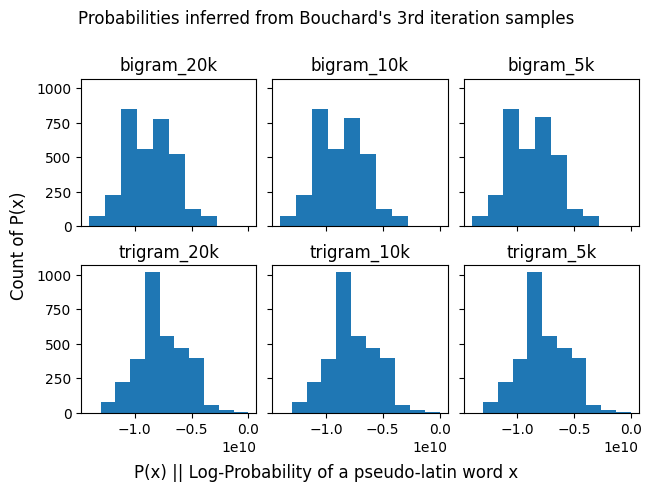

<Figure size 3000x1000 with 0 Axes>

In [28]:
import numpy as np
import matplotlib.pyplot as plt

print("Total number of samples:", len(sources[0][1]))

names = ['bigram_20k', 'bigram_10k', 'bigram_5k', 'trigram_20k', 'trigram_10k', 'trigram_5k']

# Init subplots : 2 rows for bigrams and trigrams, len(inferred_sources)//2 columns for the amount of data
fig, axs = plt.subplots(2, len(inferred_sources)//2, sharex=True, sharey=True, constrained_layout=True)

# Display for each i subplot the inferred probs of sources
for i, probs in enumerate(inferred_sources):
    probs_np = np.concatenate(probs.detach().cpu().numpy(), axis=0) # plt only work with np

    print(f"The {names[i]} model has {len(np.unique(probs_np))} unique probas") # to check that almost all probas are unique

    axs[int(i>=3), i%3].hist(probs_np)
    axs[int(i>=3), i%3].set_title(names[i])

fig.supxlabel("P(x) || Log-Probability of a pseudo-latin word x")
fig.supylabel("Count of P(x)")
fig.suptitle("Probabilities inferred from Bouchard's 3rd iteration samples\n")

plt.figure(figsize=(30,10))
plt.show()
